# Fully Connected Experiments on FashionMNIST


## 1. Setup

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import semitorch
import seaborn as sns

from collections import OrderedDict
from IPython import display
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import trange

data_path = os.path.abspath("./data" if os.path.isdir("./data") else "../data")
device = "cuda" if torch.cuda.is_available() else "cpu"

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.7
[Taichi] Starting on arch=cuda


### Load FashionMNIST data

In [2]:
batch_size = 256
num_workers = 8

transforms_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = FashionMNIST(root=".", train=True, download=True, transform=transforms_train)
testset = FashionMNIST(root=".", train=False, download=True, transform=transforms_test)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

def average_input_size(dataset: torch.Tensor) -> float:
    return torch.mean(torch.stack([torch.linalg.vector_norm(data.float()) for data in dataset])).item()

avg_input_size = np.mean([average_input_size(trainset.data), average_input_size(testset.data)])
print(avg_input_size)

3099.8472900390625


## 2. Models

In [3]:
def create_model(
        model_name: str,
        num_features: int,
        num_classes: int,
        num_layers: int = 1,
        channel_size: int = 16,
) -> nn.Sequential:
    BACKBONE_FEATURES = channel_size

    if model_name == "linear_relu":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
                     nn.ReLU(),
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
                     nn.ReLU(),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, BACKBONE_FEATURES),
            nn.ReLU(),
            nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
            nn.ReLU(),
            *layers,
        )
    elif model_name == "linear_maxplus":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
                     semitorch.MaxPlus(BACKBONE_FEATURES, BACKBONE_FEATURES),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, BACKBONE_FEATURES),
            semitorch.MaxPlus(BACKBONE_FEATURES, BACKBONE_FEATURES),
            *layers,
        )
    elif model_name == "linear_minplus":
        layers = [
                     nn.Linear(BACKBONE_FEATURES, BACKBONE_FEATURES),
                     semitorch.MinPlus(BACKBONE_FEATURES, BACKBONE_FEATURES),
                 ] * (num_layers - 1)

        backbone = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, BACKBONE_FEATURES),
            semitorch.MinPlus(BACKBONE_FEATURES, BACKBONE_FEATURES),
            *layers,
        )
    else:
        raise RuntimeError(f"Unknown model ({model_name})")

    head = nn.Linear(BACKBONE_FEATURES, num_classes, bias=False)
    model = nn.Sequential(OrderedDict([("backbone", backbone), ("head", head)]))

    model.name = model_name

    return model


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## 3. Training

In [4]:
def accuracy(model: nn.Sequential, x: torch.Tensor, y: torch.Tensor) -> float:
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)

        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model: nn.Sequential, device: str, testloader: DataLoader) -> float:
    model.eval()
    accs = []

    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))

    return sum(accs) / len(accs)


def confusion_matrix(model: nn.Sequential, device: str, testloader: DataLoader) -> None:
    model.eval()

    conf_matrix = torch.zeros(len(testset.classes), len(testset.classes))

    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)

            conf_matrix[y.cpu(), prediction] += 1

    plt.figure(figsize=(6,4))

    df_cm = pd.DataFrame(conf_matrix, index=testset.classes, columns=testset.classes).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def train(
        model: nn.Sequential,
        device: str,
        trainloader: DataLoader,
        testloader: DataLoader,
        optimizers: list[torch.optim.Optimizer],
        schedulers: list[torch.optim.lr_scheduler],
        loss: torch.nn.modules.loss,
        epochs: int,
) -> None:
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches

    fig, ax = plt.subplots(1, 1, figsize=[6, 4])
    hdisplay = display.display("", display_id=True)

    for _ in trange(epochs):
        model.train()

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            for optimizer in optimizers:
                optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))

            l = loss(yout, y.squeeze())
            l.backward()
            for optimizer in optimizers:
                if isinstance(optimizer, semitorch.SemiSGD):
                    optimizer.step(input=x.cpu())
                else:
                    optimizer.step()
            if schedulers is not None:
                for scheduler in schedulers:
                    scheduler.step()

        accs.append(test(model, device, testloader))

        ax.clear()
        ax.set_xlim(0, epochs)
        ax.set_ylim(-0.02, 1.02)
        ax.plot(
            np.linspace(0, len(accs), len(trainaccs)),
            trainaccs,
            ".",
            markersize=1.5,
            markerfacecolor=(0, 0, 1, 0.3),
        )
        ax.plot(np.linspace(1, len(accs), len(accs)), accs)
        ax.text(
            0.6 * epochs,
            0.30,
            f"max test acc = {max(accs):.2%}",
            ha="center",
            fontsize=10,
        )
        hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    confusion_matrix(model, device, testloader)

linear/relu model has 13536 trainable parameters
linear/maxplus model has 13536 trainable parameters
linear/minplus model has 13536 trainable parameters


''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

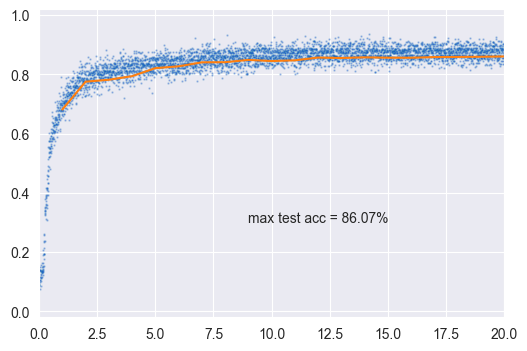

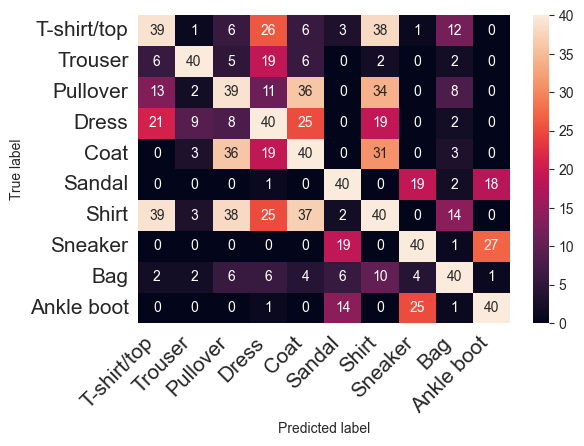

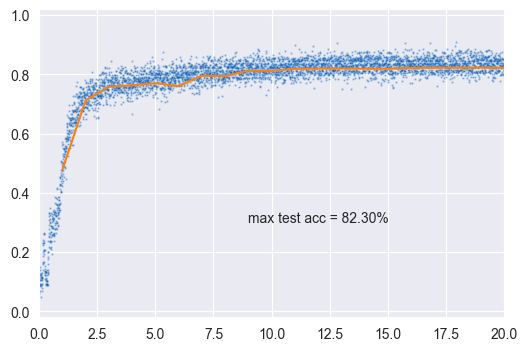

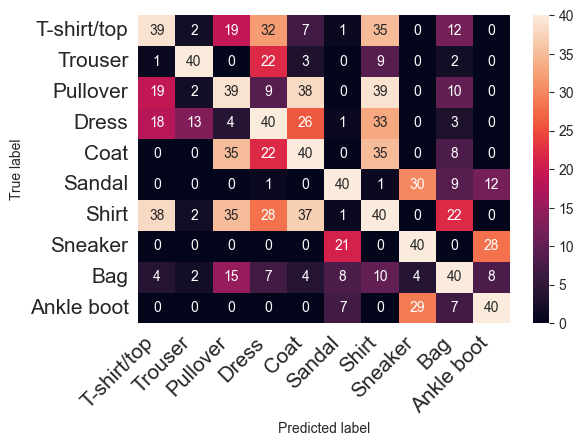

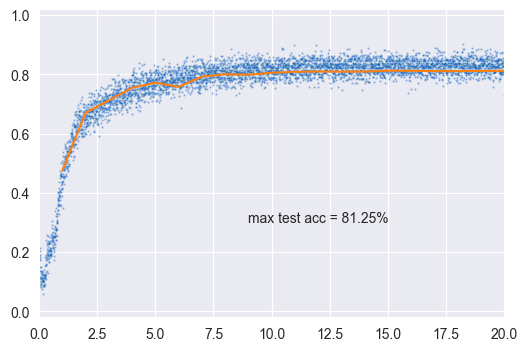

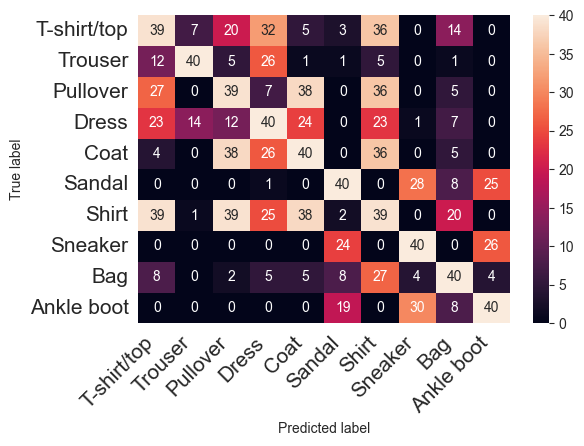

In [5]:
models = [
    create_model("linear_relu", num_features=28*28, num_classes=10, num_layers=2).to(device),
    create_model("linear_maxplus", num_features=28*28, num_classes=10, num_layers=2).to(device),
    create_model("linear_minplus", num_features=28*28, num_classes=10, num_layers=2).to(device),
]

for model in models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} trainable parameters")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in models:
    if model.name == "linear_relu":
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=6e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
    elif model.name == "linear_maxplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=5e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
    elif model.name == "linear_minplus":
        optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=5e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        trainloader,
        testloader,
        [optimizer],
        [scheduler],
        loss,
        epochs,
    )

# SGD without momentum, correcting learning rates for Semirings

First we will split the linear and semiring model parameters

In [6]:
def get_linear_model_parameters(model: nn.Sequential) -> nn.ParameterList:
    params = nn.ParameterList()

    for layer in model:
        if isinstance(layer, nn.Linear):
            params.extend(layer.parameters())
        if isinstance(layer, nn.Sequential):
            params.extend(get_linear_model_parameters(layer))

    return params


def get_semiring_model_parameters(model: nn.Sequential) -> nn.ParameterList:
    params = nn.ParameterList()

    for layer in model:
        if isinstance(layer, (semitorch.MaxPlus, semitorch.MinPlus)):
            params.extend(layer.parameters())
        if isinstance(layer, nn.Sequential):
            params.extend(get_semiring_model_parameters(layer))

    return params

linear/relu model has 13536 trainable parameters, of which 13536 are linear and 0 are semiring related
linear/maxplus model has 13536 trainable parameters, of which 12992 are linear and 544 are semiring related
linear/minplus model has 13536 trainable parameters, of which 12992 are linear and 544 are semiring related


''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

''

  0%|          | 0/20 [00:00<?, ?it/s]

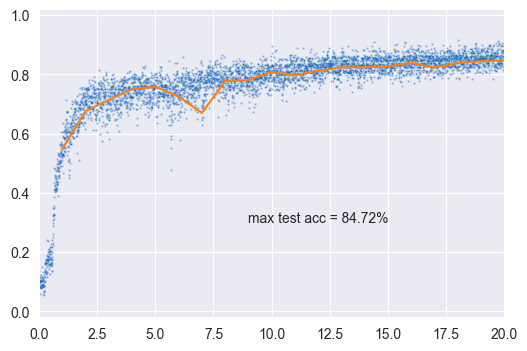

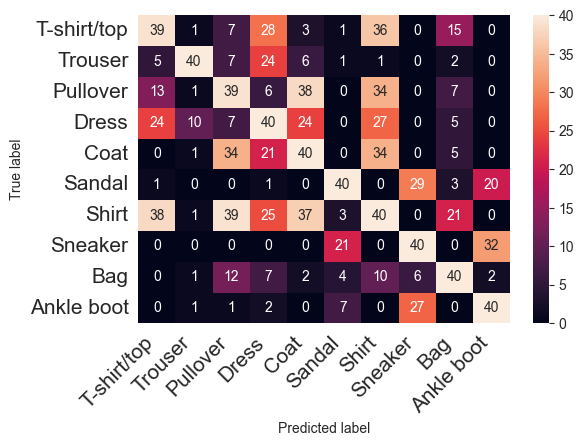

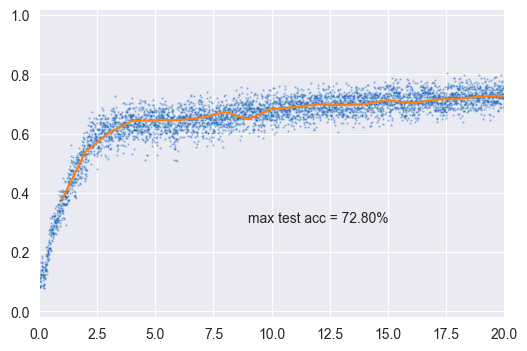

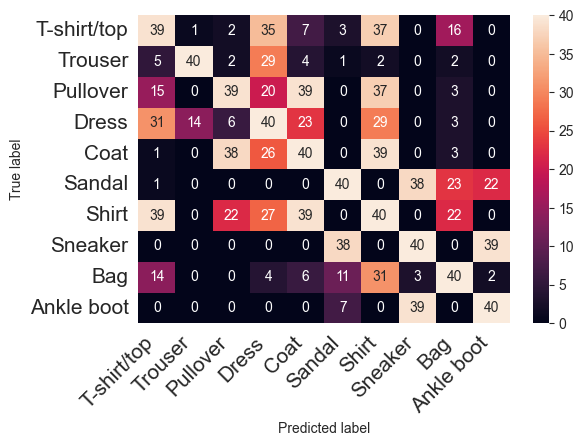

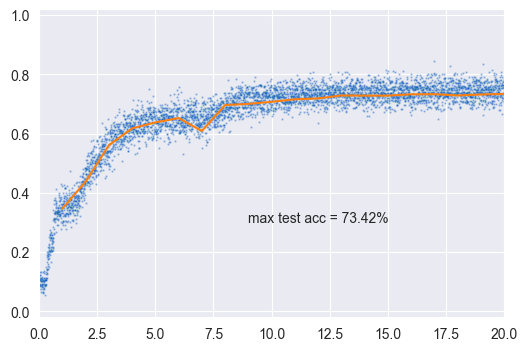

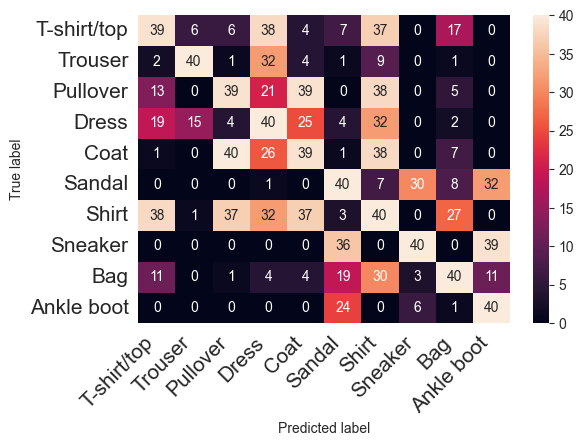

In [7]:
models = [
    create_model("linear_relu", num_features=28*28, num_classes=10, num_layers=2).to(device),
    create_model("linear_maxplus", num_features=28*28, num_classes=10, num_layers=2).to(device),
    create_model("linear_minplus", num_features=28*28, num_classes=10, num_layers=2).to(device),
]

for model in models:
    model_ref = model.name.replace("_", "/")
    print(f"{model_ref} model has {count_parameters(model)} trainable parameters, "
          f"of which {count_parameters(get_linear_model_parameters(model))} are linear "
          f"and {count_parameters(get_semiring_model_parameters(model))} are semiring related")

loss = nn.CrossEntropyLoss()
epochs = 20

for model in models:
    if model.name == "linear_relu":
        optimizer = torch.optim.SGD(model.parameters(), lr=1.4e-1, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=1.4e-1,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        optimizers = [optimizer]
        schedulers = [scheduler]
    elif model.name == "linear_maxplus":
        linear_optimizer = torch.optim.SGD(get_linear_model_parameters(model), lr=7e-3, weight_decay=0.01)
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=7e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        semiring_optimizer = torch.optim.SGD(get_semiring_model_parameters(model), lr=5e-2, weight_decay=0.01)
        semiring_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            semiring_optimizer,
            max_lr=5e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        optimizers = [linear_optimizer, semiring_optimizer]
        schedulers = [linear_scheduler, semiring_scheduler]
    elif model.name == "linear_minplus":
        linear_optimizer = torch.optim.SGD(get_linear_model_parameters(model), lr=7e-3, weight_decay=0.01)
        linear_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            linear_optimizer,
            max_lr=7e-3,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        semiring_optimizer = torch.optim.SGD(get_semiring_model_parameters(model), lr=5e-2, weight_decay=0.01)
        semiring_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            semiring_optimizer,
            max_lr=5e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=1000.0,
            div_factor=10.0,
            steps_per_epoch=len(trainloader),
            epochs=epochs,
        )
        optimizers = [linear_optimizer, semiring_optimizer]
        schedulers = [linear_scheduler, semiring_scheduler]
    else:
        raise RuntimeError(f"Unknown model ({model.name})")

    train(
        model,
        device,
        trainloader,
        testloader,
        optimizers,
        schedulers,
        loss,
        epochs,
    )

Now we will implement an adaptive corrective learning rate based on the actual input in each iteration. The goal is to check if learning rates of the linear layers are similar to those of the semiring layers.